# EDA of MIAS data set

this dataset of 322 images is from the MiniMammographic Database provided by the Mammographic Image Analysis Society (MIAS). The original MIAS Database (digitized at 50 micron pixel edge) has been reduced to 200 micron pixel edge and clipped/padded so that every image is 1024 pixels x 1024 pixels. 

The source of the data set can be found here:

http://peipa.essex.ac.uk/info/mias.html

### Images:
- all images are in grayscale (0 to 255) and have a size of 1024 x 1024 pixels.
- There are a total of 322 images.  the images come in pairs, where even file names are the left breast, and odd images are the right breast of one patient.  The images alternate in direction.  that is, images and of the left breast 'face' to the left of the frame, and the right breast the reverse.
- some images have tags and notes in the upper corners, or white bars on the edges as artifacts from the physical copy.

### Data Dictionary (from the data set origin) :
1st column: MIAS database reference number.

2nd column: Character of background tissue:
- F  Fatty
- G  Fatty-glandular
- D  Dense-glandular
  
3rd column: Class of abnormality present:
- CALC  Calcification
- CIRC  Well-defined/circumscribed masses
- SPIC  Spiculated masses
- MISC  Other, ill-defined masses
- ARCH  Architectural distortion
- ASYM  Asymmetry
- NORM  Normal
  
4th column: Severity of abnormality
- B  Benign
- M  Malignant
  
5th, 6th columns: x,y image-coordinates of centre of abnormality.  

7th column: Approximate radius (in pixels) of a circle enclosing the abnormality.


There are also several things you should note:
1. The list is arranged in pairs of films, where each pair represents the left (even filename numbers) and right mammograms (odd filename numbers) of a single patient.
2. The size of all the images is 1024 pixels x 1024 pixels. The images have been centered in the matrix.
3. When calcifications are present, centre locations and radii apply to clusters rather than individual calcifications. Coordinate system origin is the bottom-left corner.
4. In some cases calcifications are widely distributed throughout the image rather than concentrated at a single site. In these cases centre locations and radii are inappropriate and have been omitted.

### Additional notes:
- X,Y Origin is at the lower left of the image
- There are 330 observations in the label csv, vs 322 images.  Some images have multiple tumors.  In this case, multiple observations are entered into the label csv.

## References
1. MIAS Data Source: http://peipa.essex.ac.uk/info/mias.html
2. DDSM Data Source: https://www.kaggle.com/skooch/ddsm-mammography
3. CBIS-DDSM Data Source (EDA): https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM
3. https://www.kaggle.com/kmader/mias-mammography
4. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5954872/
5. https://pubmed.ncbi.nlm.nih.gov/24209932/
6. https://core.ac.uk/download/pdf/21748057.pdf
7. https://www.nature.com/articles/sdata2017177

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
import glob


## Pull in images and labels
- add column 'tumor' as a binary 1 or 0 for if there's a tumor present or not
- add a 'N' for none in the diagnosis column if no tumor present (replacing Null)

Update the file location for the images as needed

The labels come from the csv 'info_red.csv' in the 'mias_data' folder

In [19]:
# check to make sure that the file_location matches the folder where the images are stored
# the file string must end with /mdb* to pull in the pictures correctly
file_location = 'mias_data/mdb*'

In [20]:
images = []
labels = []
files = glob.glob(file_location)
for file in files:
    image = cv2.imread(file,0)
    images.append(image)

In [22]:
labels = pd.read_csv('mias_data/info_red.csv',delimiter=' ',names=['ID','bg','ab_type','diagnosis','ab_x','ab_y','ab_r'])

labels['diagnosis'].fillna('N',inplace=True)
labels['tumor'] = labels['diagnosis'].map(lambda x: 0 if x == 'N' else 1)
#labels['ID'] = labels['ID'].map(lambda x: x[3:])
# labels['ab_x'].fillna(512,inplace=True)
# labels['ab_y'].fillna(512,inplace=True)
# labels['ab_r'].fillna(0,inplace=True)
# labels.drop_duplicates(subset='ID', inplace = True)

## First ten images in the data set:

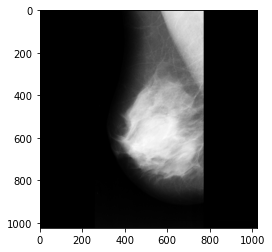

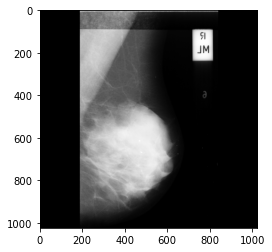

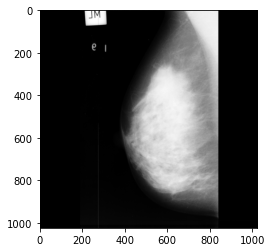

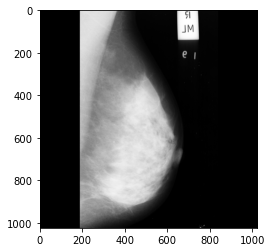

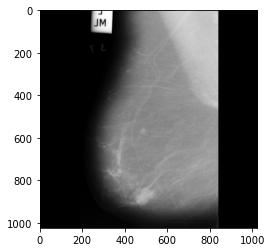

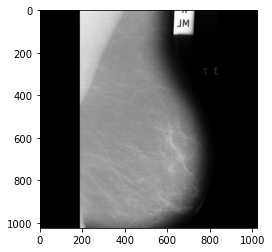

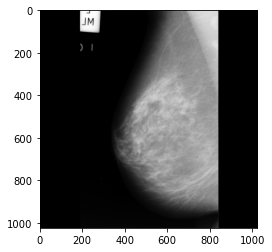

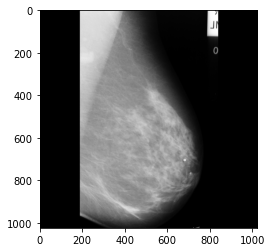

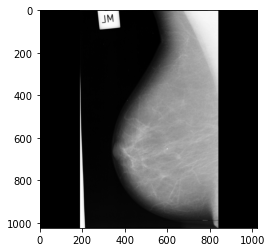

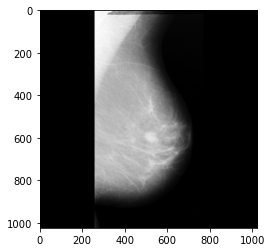

In [5]:
for i in range(10):
    plt.imshow(images[i],cmap=plt.get_cmap('gray'))
    plt.show()

# Label EDA

In [6]:
labels.head()

,ID,bg,ab_type,diagnosis,ab_x,ab_y,ab_r,tumor
0,mdb001,G,CIRC,B,535,425,197.0,1
1,mdb002,G,CIRC,B,522,280,69.0,1
2,mdb003,D,NORM,N,NaN,NaN,NaN,0
3,mdb004,D,NORM,N,NaN,NaN,NaN,0
4,mdb005,F,CIRC,B,477,133,30.0,1


In [7]:
labels['tumor'].value_counts(normalize=True)

0    0.627273
1    0.372727
Name: tumor, dtype: float64

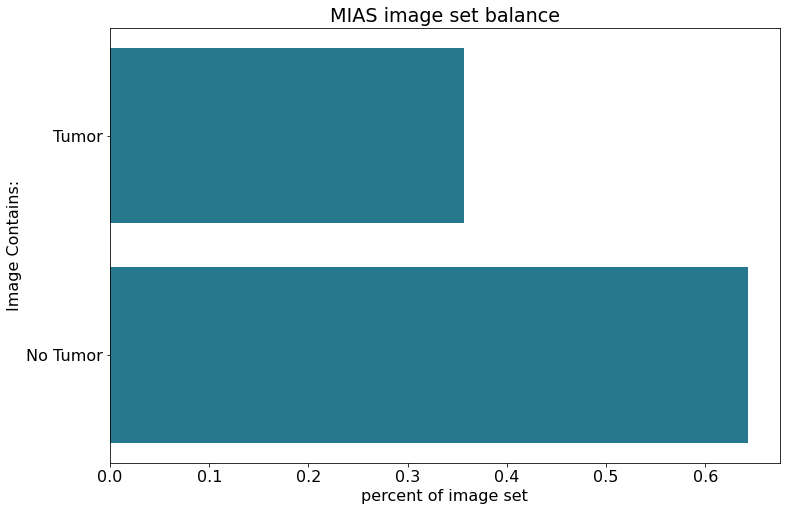

In [8]:
# determine between tumor and no tumor data
# Remove duplicate data for this binary comparison

temp_df = pd.DataFrame()
temp_df = labels.drop_duplicates(subset='ID')
height = list(temp_df['tumor'].value_counts(normalize=True))
bar_names = []
for index_item in list(temp_df['tumor'].value_counts(normalize=True).index):
    if index_item == 1:
        bar_names.append('Tumor')
    else:
        bar_names.append('No Tumor')


# Generate Graph
plt.rcParams.update({'font.size': 16})

plt.figure(figsize = (12,8))

plt.barh(bar_names, height, color = (38/255,120/255,142/255))
 
plt.title('MIAS image set balance')
plt.xlabel('percent of image set')
plt.ylabel('Image Contains:')

plt.show()

In [9]:
labels['ab_type'].value_counts(normalize = True)

NORM    0.627273
CALC    0.090909
CIRC    0.075758
SPIC    0.057576
ARCH    0.057576
MISC    0.045455
ASYM    0.045455
Name: ab_type, dtype: float64

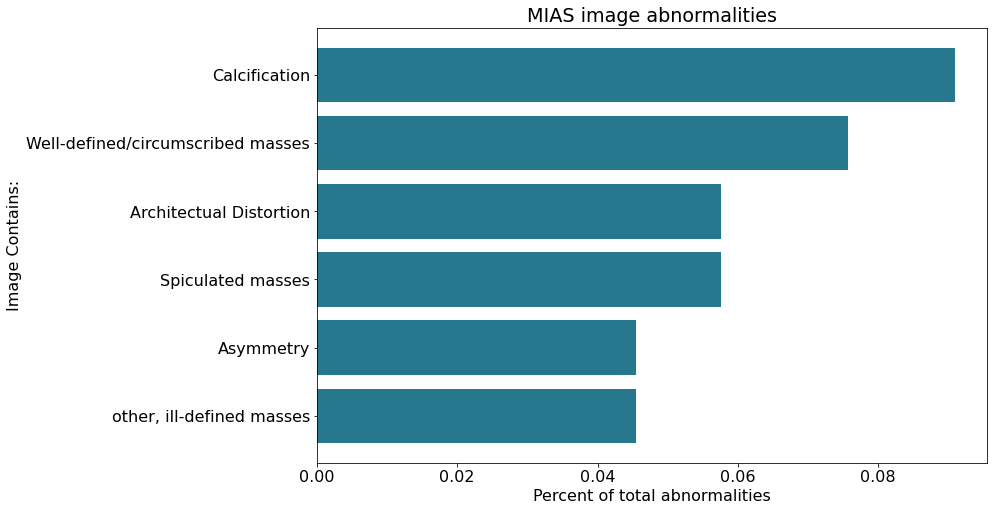

In [10]:
# dictionary to convert acronyms to full words
ab_type_conversion = {'ASYM': 'Asymmetry',
                      'MISC': 'other, ill-defined masses',
                      'ARCH': 'Architectual Distortion',
                      'SPIC': 'Spiculated masses',
                      'CIRC': 'Well-defined/circumscribed masses',
                      'CALC': 'Calcification',
                      'ASYM': 'Asymmetry',
                      'NORM': 'Normal'
                     }        
# pull out value counts, drop normal, and sort small to large
temp_df = pd.DataFrame()
temp_df = labels['ab_type'].value_counts(normalize = True).drop(index = 'NORM').sort_values()
height = list(temp_df)
# pull out names corresponding to numbers
bar_names = []
for index_item in list(temp_df.index):
    bar_names.append(ab_type_conversion[index_item])

plt.rcParams.update({'font.size': 16})

plt.figure(figsize = (12,8))
plt.barh(bar_names, height, color = (38/255,120/255,142/255))
 
# Create names on the x-axis
#plt.yticks(y_pos, bar_names)
plt.title('MIAS image abnormalities')
plt.xlabel('Percent of total abnormalities')
plt.ylabel('Image Contains:')
# Show graphic
plt.show()

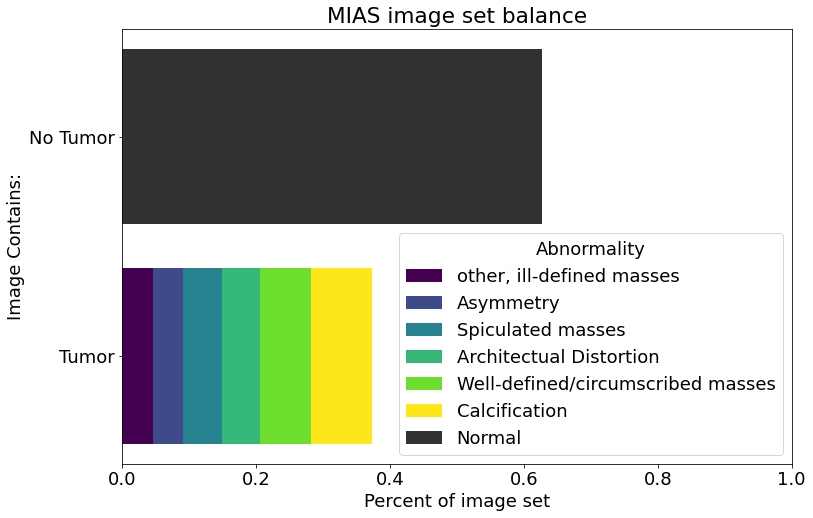

In [11]:
# pull out all normalized ab_type count values with 'NORM'
temp_df = pd.DataFrame()
temp_df = labels['ab_type'].value_counts(normalize = True).sort_values()
# append each stacked bar chart
bars = []
for num in temp_df.drop(index = 'NORM'):
    bars.append([num,0])
bars.append([0,temp_df['NORM']])

# build legend list
height = list(temp_df)
# pull out names corresponding to numbers
legend = []
for index_item in list(temp_df.index):
    legend.append(ab_type_conversion[index_item])

# Set color scheme for chart
colors1 = [(68/255,1/255,84/255),
          (62/255,74/255,137/255),
          (38/255,130/255,142/255),
          (53/255,183/255,121/255),
          (109/255,222/255,44/255),
          (253/255,231/255,27/255),
          (50/255,50/255,50/255)
         ]

colors = ['red','orange','yellow','green','blue','violet','black']

plt.rcParams.update({'font.size': 18})

# Heights of bars1 + bars2
#bars = np.add(bars1, bars2).tolist()
 
# The position of the bars on the x-axis
r = ['Tumor', 'No Tumor']
 
# Names of group and bar width
#names = ['A','B','C','D','E']
#barWidth = 1

plt.figure(figsize = (12,8))

# Create brown bars
plt.barh(r, bars[0], color=colors1[0])
for item in range(1,7):
    plt.barh(r, bars[item], left = [sum([ x[0] for x in bars[0:item]]),0], color=colors1[item])
    
plt.title('MIAS image set balance')
plt.xlabel('Percent of image set')
plt.ylabel('Image Contains:')
plt.xlim(0, 1)

plt.legend(legend, loc = 'lower right', title = 'Abnormality')

In [12]:
labels['bg'].value_counts(normalize = True)

D    0.354545
F    0.330303
G    0.315152
Name: bg, dtype: float64

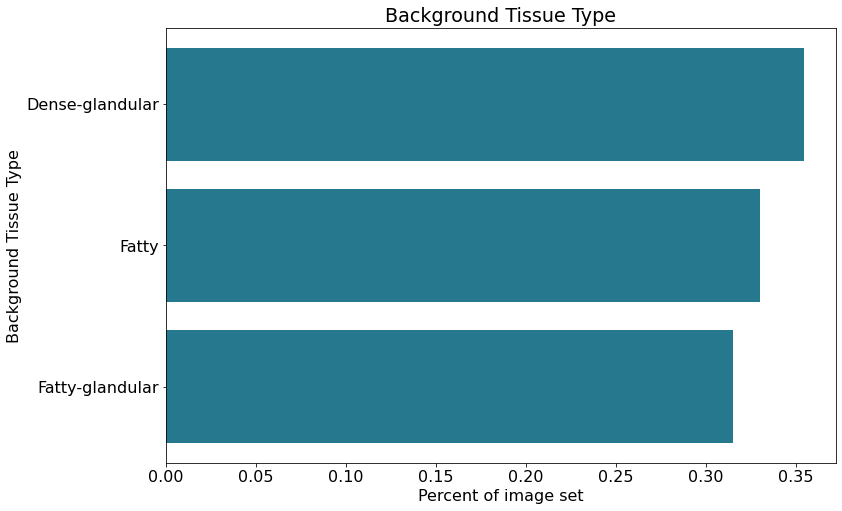

In [13]:
# conversion chart for tissue type (bg)
bg_conversion = {
    'F': 'Fatty',
    'G': 'Fatty-glandular',
    'D': 'Dense-glandular'}

# Extract normalized counts of each tissue type
temp_df = pd.DataFrame()
temp_df = labels['bg'].value_counts(normalize = True).sort_values()
# Extract column names, and convert to words
height = temp_df.values
bar_names = []
for index_item in list(temp_df.index):
    bar_names.append(bg_conversion[index_item])

# Create Graph
plt.rcParams.update({'font.size': 16})

plt.figure(figsize = (12,8))
plt.barh(bar_names, height, color = (38/255,120/255,142/255))
 

plt.title('Background Tissue Type')
plt.xlabel('Percent of image set')
plt.ylabel('Background Tissue Type')

plt.show()

Text(0, 0.5, 'Background Tissue Type')

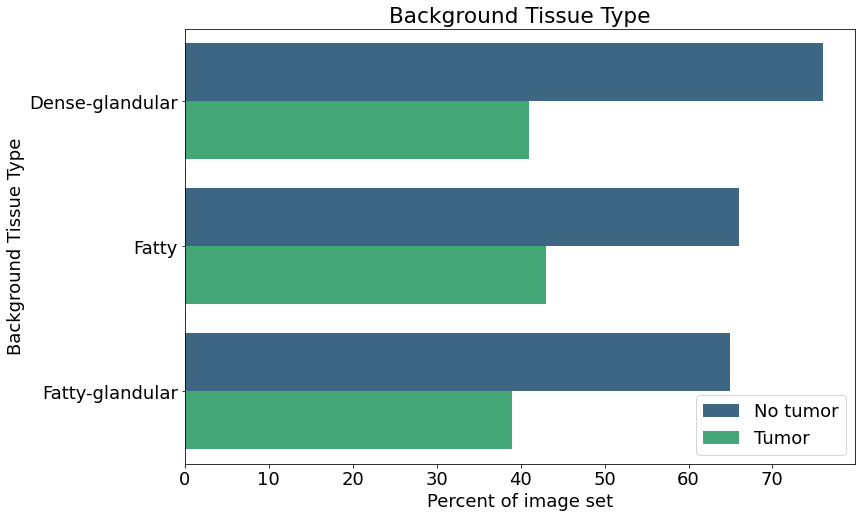

In [15]:

# Configure data frame for output
temp_df = pd.DataFrame(labels.groupby(by=['bg','tumor'])[['tumor']].count())
temp_df.rename(columns = {'tumor':'counts'}, inplace = True)
temp_df.reset_index(inplace = True)
temp_df['bg'] = temp_df['bg'].map(lambda x: bg_conversion[x])
temp_df['tumor'] = temp_df['tumor'].map(lambda x: 'Tumor' if x == 1 else 'No tumor')



# create graph
plt.rcParams.update({'font.size': 18})

plt.figure(figsize = (12,8))

sns.barplot(x="counts", y="bg", hue="tumor", data=temp_df, ci=None, palette = 'viridis');
plt.legend(loc = 'lower right')
#[(62,74,137),(109,205,89)]
#y_pos = np.arange(len(bars))

# plt.rcParams.update({'font.size': 16})

# plt.figure(figsize = (12,8))
# plt.barh(bar_names, height, color = (38/255,120/255,142/255))
 
# # Create names on the x-axis
# #plt.yticks(y_pos, bar_names)
plt.title('Background Tissue Type')
plt.xlabel('Percent of image set')
plt.ylabel('Background Tissue Type')
# # Show graphic
# plt.show()

Show images that have multiple tumors

In [16]:
# Show labels that have duplicates
labels['ID'].value_counts()[0:15]

mdb226    3
mdb223    2
mdb249    2
mdb144    2
mdb005    2
mdb239    2
mdb132    2
mdb009    1
mdb053    1
mdb012    1
mdb186    1
mdb273    1
mdb108    1
mdb043    1
mdb264    1
Name: ID, dtype: int64